In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

2023-01-19 05:10:16.940314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create training data set

In [2]:
def create_training_data(dir_path):
    
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v9_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v9_emseed.root")
    
    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()
    bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()
    
    pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()
    deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()
    selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4)
    
    pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()
    deltaR_bkg = bkg['ntuplePupSingle']['tree']['gendr1'].array()
    selection_bkg = pt_bkg > 20
    
    #Maybe better to use 2.4 for eta
    
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.asarray(sig_input[selection_sig])
    y_sig = np.full(X_sig.shape[0], 1)
    
    X_bkg = np.asarray(bkg_input[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0)
    
    X = np.concatenate([X_sig, X_bkg])
    y = np.concatenate([y_sig, y_bkg])
    
    index = np.arange(X.shape[0])
    
    X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, index, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, index_train, index_test

In [4]:
X_train, X_test, y_train, y_test, index_train, index_test = create_training_data("../ntuples/Jan_19_2023")

In [5]:
#Save the arrays
np.save("../ntuples/Jan_19_2023/X_train.npy", X_train)
np.save("../ntuples/Jan_19_2023/X_test.npy", X_test)

np.save("../ntuples/Jan_19_2023/y_train.npy", y_train)
np.save("../ntuples/Jan_19_2023/y_test.npy", y_test)

np.save("../ntuples/Jan_19_2023/index_train.npy", index_train)
np.save("../ntuples/Jan_19_2023/index_test.npy", index_test)

## Model

In [7]:
model = Sequential()
model.add(Dense(25, activation = 'relu', input_shape=X_train.shape[1:]))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                2025      
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,406
Trainable params: 2,406
Non-trainable params: 0
_________________________________________________________________


2023-01-19 05:11:52.675627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 05:11:52.687973: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)
 
model.fit(X_train, y_train,
          epochs=50,
          batch_size=50,
          verbose=2,
          validation_split=0.20,
          callbacks=[callback])

Epoch 1/50
2538/2538 - 24s - loss: 0.3767 - binary_accuracy: 0.8304 - val_loss: 0.3355 - val_binary_accuracy: 0.8557 - 24s/epoch - 9ms/step
Epoch 2/50
2538/2538 - 25s - loss: 0.3319 - binary_accuracy: 0.8554 - val_loss: 0.3307 - val_binary_accuracy: 0.8567 - 25s/epoch - 10ms/step
Epoch 3/50
2538/2538 - 21s - loss: 0.3266 - binary_accuracy: 0.8584 - val_loss: 0.3273 - val_binary_accuracy: 0.8584 - 21s/epoch - 8ms/step
Epoch 4/50
2538/2538 - 22s - loss: 0.3233 - binary_accuracy: 0.8596 - val_loss: 0.3257 - val_binary_accuracy: 0.8592 - 22s/epoch - 9ms/step
Epoch 5/50
2538/2538 - 23s - loss: 0.3220 - binary_accuracy: 0.8596 - val_loss: 0.3258 - val_binary_accuracy: 0.8571 - 23s/epoch - 9ms/step
Epoch 6/50
2538/2538 - 23s - loss: 0.3205 - binary_accuracy: 0.8602 - val_loss: 0.3252 - val_binary_accuracy: 0.8577 - 23s/epoch - 9ms/step
Epoch 7/50
2538/2538 - 24s - loss: 0.3189 - binary_accuracy: 0.8611 - val_loss: 0.3245 - val_binary_accuracy: 0.8573 - 24s/epoch - 9ms/step
Epoch 8/50
2538/253

In [9]:
#Save the model
model.save('../models/L1Tau_v4_EmSeed.h5')

## Performance Plots

### ROC curve on test set

In [10]:
y_pred = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_score = round(auc(fpr, tpr),2)

1239/1239 [==============================] - 7s 6ms/step


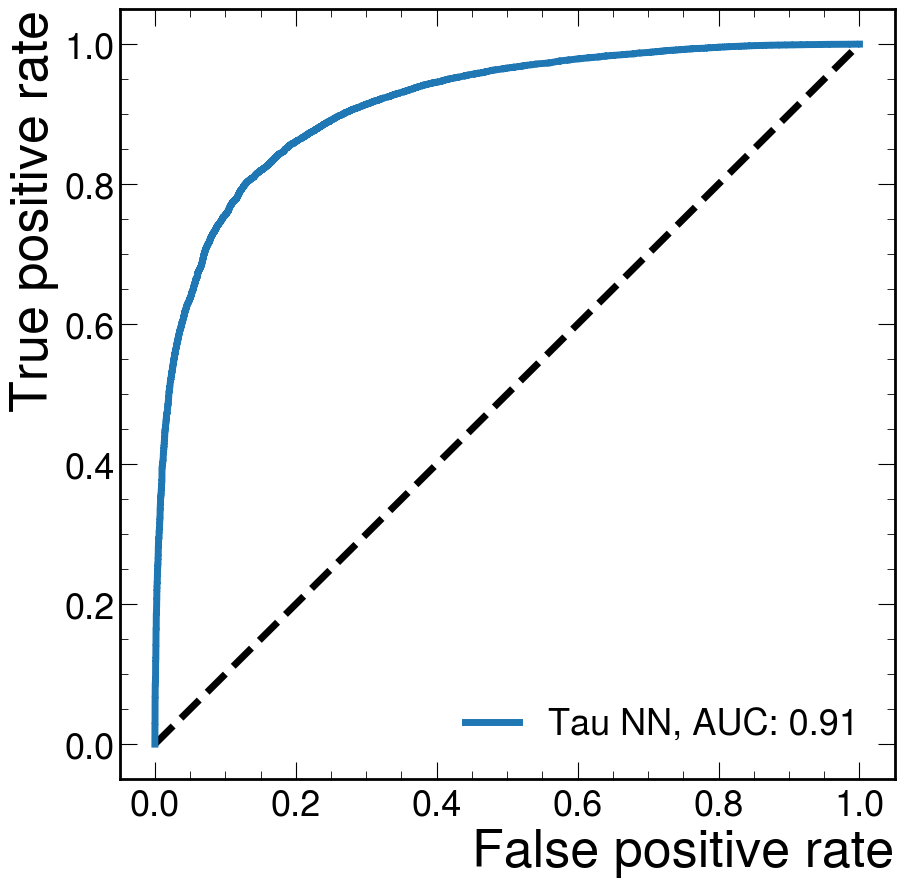

In [11]:
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label = 'Tau NN, AUC: {}'.format(auc_score))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

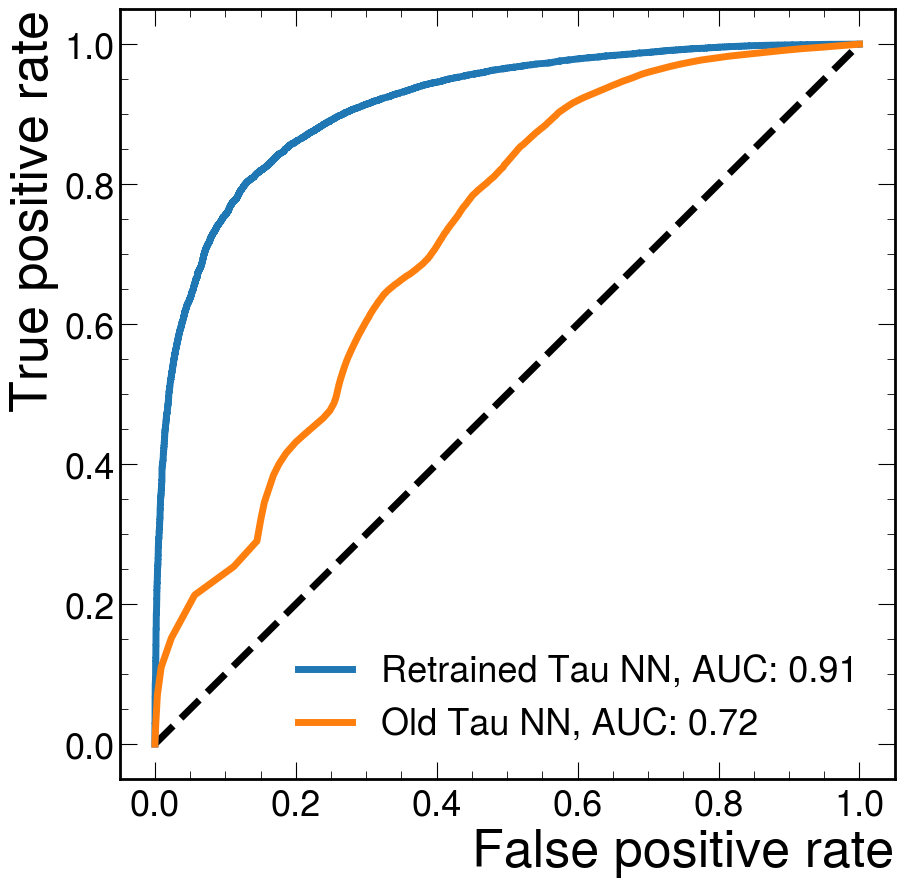

In [12]:
def get_chargedIso(indir):
    
    sig = uproot4.open(indir+"/test_sig_v9_emseed.root")
    bkg = uproot4.open(indir+"/test_bkg_v9_emseed.root")
    
    #signal
    pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()
    deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()
    
    selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4)
    
    nn_score_sig = sig['ntuplePupSingle']['tree']['chargedIso'].array()
    
    selected_sig_score = np.asarray(nn_score_sig[selection_sig])
    true_id_sig = np.full(selected_sig_score.shape, 1) #All 1s because this is the signal sample
    
    #background
    pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()
    deltaR_bkg = bkg['ntuplePupSingle']['tree']['gendr1'].array()
    
    selection_bkg = pt_bkg > 20
    nn_score_bkg = bkg['ntuplePupSingle']['tree']['chargedIso'].array()
    
    selected_bkg_score = np.asarray(nn_score_bkg[selection_bkg])
    true_id_bkg = np.full(selected_bkg_score.shape, 0)
    
    nn_score = np.concatenate([selected_sig_score, selected_bkg_score])
    true_id = np.concatenate([true_id_sig, true_id_bkg])
    
    fpr, tpr, thresholds = roc_curve(true_id, nn_score,pos_label=1)
    auc_score = round(auc(fpr, tpr),2)
    
    return fpr, tpr, auc_score

#Plot for charged iso aswell
fpr_iso, tpr_iso, auc_score_iso = get_chargedIso('../ntuples/Jan_19_2023/')
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label = 'Retrained Tau NN, AUC: {}'.format(auc_score))
plt.plot(fpr_iso, tpr_iso, label = 'Old Tau NN, AUC: {}'.format(auc_score_iso))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()